In [1]:
import pandas as pd 
import numpy as np
import cv2 
import os
from PIL import Image
import torch 
from torch.utils.data import Dataset, DataLoader
from torch.cuda.amp import autocast, GradScaler
import torch.nn.functional as F
from matplotlib import pyplot as plt
from torch import nn
import torchvision.models as models
from torch.optim.lr_scheduler import ReduceLROnPlateau, CosineAnnealingWarmRestarts
import albumentations as albu
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import confusion_matrix
from torch.optim import Adam
import random
import sys
sys.path.append('../input/efficientnet-pytorch/EfficientNet-PyTorch/EfficientNet-PyTorch-master')

sys.path.append('/workspace/pytorch-image-models-master')

import timm
import time

In [2]:
# train_path = '../input/cassava-leaf-disease-classification/train.csv'
# train_image_path = '../input/cassava-leaf-disease-classification/train_images/'
# test_image_path = '../input/cassava-leaf-disease-classification/test_images/'
model_path = './'

train_path = '/workspace/train.csv'
train_image_path = '/workspace/train_images/'
test_image_path = '/workspace/test_images/'

nfold = 5
EPOCH = 11
batch_size =16
image_dim = 512
early_stopping = 8
CUDA_LAUNCH_BLOCKING=1

In [3]:
# def seed_everything(seed=105):
#     random.seed(seed)
#     os.environ['PYTHONHASHSEED'] = str(seed)
#     np.random.seed(seed)
#     torch.manual_seed(seed)
#     torch.cuda.manual_seed(seed)
#     torch.backends.cudnn.deterministic = True
    
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

In [4]:
device = ('cuda' if torch.cuda.is_available() else 'cpu')

In [5]:
device

'cuda'

In [6]:
train = pd.read_csv(train_path)

In [7]:
train.head()

,image_id,label
0,1000015157.jpg,0
1,1000201771.jpg,3
2,100042118.jpg,1
3,1000723321.jpg,1
4,1000812911.jpg,3


In [8]:
print("Train shape is..{}".format(train.shape))

Train shape is..(21397, 2)


In [9]:
target_col = 'label'
nclasses = train[target_col].nunique()

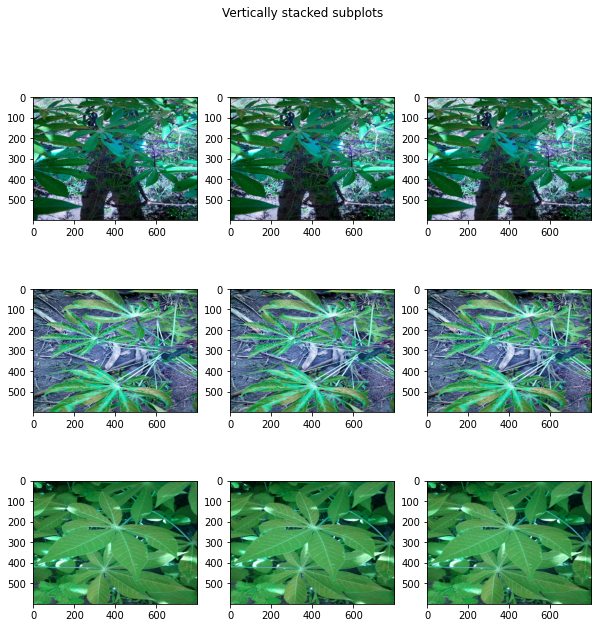

In [10]:
# Load an image..
fig, axs = plt.subplots(ncols=3, nrows=3, figsize=(10, 10))

for col in range(3):
    for iter in range(3):
        image_id = os.path.join(train_image_path, train.iloc[iter]['image_id'])
        
        image = cv2.imread(image_id)
        
        fig.suptitle('Vertically stacked subplots')
        axs[iter][col].imshow(image)
        axs[iter][col].imshow(image)
        axs[iter][col].imshow(image)

In [11]:
train

,image_id,label
0,1000015157.jpg,0
1,1000201771.jpg,3
2,100042118.jpg,1
3,1000723321.jpg,1
4,1000812911.jpg,3
...,...,...
21392,999068805.jpg,3
21393,999329392.jpg,3
21394,999474432.jpg,1
21395,999616605.jpg,4


In [12]:
class TrainDataset(Dataset):
    
    def __init__(self, df, target_col, transform, data_type):
        self.df = df
        self.target = target_col
        self.transform = transform
        self.data_type = data_type
        
    def __getitem__(self, ind):
        
        target = dict()
        
        # Extract Image Id
        image_id = self.df.iloc[ind]['image_id']
        image_path = os.path.join(train_image_path, image_id)
        
        
        # Read image 
        imag = np.array(cv2.imread(image_path))
        #imag = np.float32(imag)
        
       
        
        imag = cv2.cvtColor(imag, cv2.COLOR_BGR2RGB) 
        #print(image.shape)
        
        #print(image_path, image)
        #print(image.shape)
            
        
        data = {
            "x": imag,
            "y":self.df.iloc[ind][target_col]
        }
        
        #print("before...",imag)
        
        if self.transform:
            trans = get_train_transforms()
            data['x'] = trans(image = data['x'])['image']
        #print("after....",data['x'])
            
        #print("before shape is.................", data['x'].shape)
        
            
        
        return data
    
    def resize_image(self, image):
        
        image = cv2.resize(image, (image_dim, image_dim))
        
        return image
        
        
    def __len__(self):
        return self.df.shape[0]
    
    
    
class TestDataset(Dataset):
    
    def __init__(self, df, target_col):
    
        self.df = df
        self.target = target_col
        
    def __getitem__(self, index):
        
        target = dict()
        
        # Extract Image Id
        image_id = self.df.iloc[ind]['image_id']
        image_path = os.path.join(train_image_path, image_id)
        
        # Read image 
        image = np.array(cv2.imread(image_path))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) 
        
        data = {
            "x": np.float32(image)
        }
        
        return data
    
    def resize_image(self, image):
        
        image = cv2.resize(image, (image_dim, image_dim))
        
        return image

        
        
    def __len__(self):
        return self.df.shape[0]
    

In [13]:
# model  = models.resnet18(pretrained=True)


In [14]:
# for param in model.parameters():
#     print(param.requires_grad)

In [15]:
# nn.Sequential(*(list(model.children())[:-1]))

In [16]:
class Model(nn.Module):
    
    def __init__(self, in_feat, n_classes):
        super().__init__()
        
#         #self.model = models.resnet18(pretrained=False)
#         #self.model =  EfficientNet.from_name('efficientnet-b1')
#         self.model = timm.create_model('resnext50_32x4d', pretrained=True)
        
#         #self.resnet = nn.Sequential(*list(self.model.children())[:-1])
#         self.model.fc = nn.Sequential(nn.Linear(in_features=2048, out_features=n_classes))
        
        self.model = timm.create_model('tf_efficientnet_b4_ns', pretrained=True)
        n_features = self.model.classifier.in_features
        self.model.classifier = nn.Linear(n_features, n_classes)
        
    def forward(self, input_x):
        out1 = self.model(input_x)
        out1 = out1.view(out1.size(0), -1)
        #output = self.fc(out1)
        return out1


In [17]:
# Model(1000, 5)

In [18]:
def rand_bbox(size, lam):
    W = size[2]
    H = size[3]
    cut_rat = np.sqrt(1. - lam)
    cut_w = np.int(W * cut_rat)
    cut_h = np.int(H * cut_rat)

    # uniform
    cx = np.random.randint(W)
    cy = np.random.randint(H)

    bbx1 = np.clip(cx - cut_w // 2, 0, W)
    bby1 = np.clip(cy - cut_h // 2, 0, H)
    bbx2 = np.clip(cx + cut_w // 2, 0, W)
    bby2 = np.clip(cy + cut_h // 2, 0, H)
    return bbx1, bby1, bbx2, bby2

def cutmix(data, target, alpha):
    indices = torch.randperm(data.size(0))
    shuffled_data = data[indices]
    shuffled_target = target[indices]

    lam = np.clip(np.random.beta(alpha, alpha),0.3,0.4)
    bbx1, bby1, bbx2, bby2 = rand_bbox(data.size(), lam)
    new_data = data.clone()
    new_data[:, :, bby1:bby2, bbx1:bbx2] = data[indices, :, bby1:bby2, bbx1:bbx2]
    # adjust lambda to exactly match pixel ratio
    lam = 1 - ((bbx2 - bbx1) * (bby2 - bby1) / (data.size()[-1] * data.size()[-2]))
    targets = (target, shuffled_target, lam)

    return new_data, targets

def fmix(data, targets, alpha, decay_power, shape, max_soft=0.0, reformulate=False):
    lam, mask = sample_mask(alpha, decay_power, shape, max_soft, reformulate)
    #mask =torch.tensor(mask, device=device).float()
    indices = torch.randperm(data.size(0))
    shuffled_data = data[indices]
    shuffled_targets = targets[indices]
    x1 = torch.from_numpy(mask).to(device)*data
    x2 = torch.from_numpy(1-mask).to(device)*shuffled_data
    targets=(targets, shuffled_targets, lam)
    
    return (x1+x2), targets

In [19]:
from albumentations.pytorch import ToTensorV2
from albumentations import (
    HorizontalFlip, VerticalFlip, IAAPerspective, ShiftScaleRotate, CLAHE, RandomRotate90,
    Transpose, ShiftScaleRotate, Blur, OpticalDistortion, GridDistortion, HueSaturationValue,
    IAAAdditiveGaussianNoise, GaussNoise, MotionBlur, MedianBlur, IAAPiecewiseAffine, RandomResizedCrop,
    IAASharpen, IAAEmboss, RandomBrightnessContrast, Flip, OneOf, Compose, Normalize, Cutout, CoarseDropout, ShiftScaleRotate, CenterCrop, Resize
)


def augmentation(img, dataset_type):
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    
    if dataset_type == 'train':
        
        print("train......................")
        aug = albu.Compose([
                        RandomResizedCrop(512, 512),
            Transpose(p=0.5),
            HorizontalFlip(p=0.5),
            VerticalFlip(p=0.5),
            ShiftScaleRotate(p=0.5),
            HueSaturationValue(hue_shift_limit=0.2, sat_shift_limit=0.2, val_shift_limit=0.2, p=0.5),
            RandomBrightnessContrast(brightness_limit=(-0.1,0.1), contrast_limit=(-0.1, 0.1), p=0.5),
            Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], max_pixel_value=255.0, p=1.0),
            CoarseDropout(p=0.5),
            Cutout(p=0.5),
            ToTensorV2(p=1.0),
                        
                    ], p=1.)
    elif dataset_type == 'valid':
        aug = albu.Compose([
                         albu.CenterCrop(image_dim, image_dim, p=1.),
                        albu.Resize(image_dim, image_dim),
                        albu.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], max_pixel_value=255.0, p=1.0),
        ], p=1.)
        
    elif dataset_type == 'test':
        aug = albu.Compose([
                    albu.Normalize(mean=mean, std=std, always_apply=True)
        ])
    
        
    return aug

        

In [20]:
from albumentations import (
    HorizontalFlip, VerticalFlip, IAAPerspective, ShiftScaleRotate, CLAHE, RandomRotate90,
    Transpose, ShiftScaleRotate, Blur, OpticalDistortion, GridDistortion, HueSaturationValue,
    IAAAdditiveGaussianNoise, GaussNoise, MotionBlur, MedianBlur, IAAPiecewiseAffine, RandomResizedCrop,
    IAASharpen, IAAEmboss, RandomBrightnessContrast, Flip, OneOf, Compose, Normalize, Cutout, CoarseDropout, ShiftScaleRotate, CenterCrop, Resize
)

from albumentations.pytorch import ToTensorV2

def get_train_transforms():
    return Compose([
            RandomResizedCrop(512, 512),
            Transpose(p=0.5),
            HorizontalFlip(p=0.5),
            VerticalFlip(p=0.5),
            ShiftScaleRotate(p=0.5),
            HueSaturationValue(hue_shift_limit=0.2, sat_shift_limit=0.2, val_shift_limit=0.2, p=0.5),
            RandomBrightnessContrast(brightness_limit=(-0.1,0.1), contrast_limit=(-0.1, 0.1), p=0.5),
            Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], max_pixel_value=255.0, p=1.0),
            CoarseDropout(p=0.5),
            Cutout(p=0.5),
            ToTensorV2(p=1.0),
        ], p=1.)
  
        
def get_valid_transforms():
    return Compose([
            CenterCrop(CFG['img_size'], CFG['img_size'], p=1.),
            Resize(CFG['img_size'], CFG['img_size']),
            Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], max_pixel_value=255.0, p=1.0),
            ToTensorV2(p=1.0),
        ], p=1.)

In [21]:
results = dict()
oof = np.zeros(len(train))

In [22]:
oof.shape

(21397,)

In [23]:
def accuracy(true,pred):
    train_acc = torch.sum(pred == true)
    final_train_acc = train_acc.item()/len(pred)
    return final_train_acc

In [24]:
# t1 = torch.Tensor([1,2,3])
# t2 = torch.Tensor([0,2,3])

In [25]:
# a = accuracy(t1, t2)
# print(a)

In [26]:
class CFG:
    debug=False
    apex=False
    print_freq=100
    num_workers=4
    model_name='resnext50_32x4d'
    size=256
    scheduler='CosineAnnealingWarmRestarts' # ['ReduceLROnPlateau', 'CosineAnnealingLR', 'CosineAnnealingWarmRestarts']
    epochs=10
    #factor=0.2 # ReduceLROnPlateau
    #patience=4 # ReduceLROnPlateau
    #eps=1e-6 # ReduceLROnPlateau
    #T_max=10 # CosineAnnealingLR
    T_0=10 # CosineAnnealingWarmRestarts
    lr=1e-4
    min_lr=1e-6
    batch_size=32
    weight_decay=1e-6
    gradient_accumulation_steps=1
    max_grad_norm=1000
    seed=456789
    target_size=5
    target_col='label'
    n_fold=5
    trn_fold=[0, 1, 2, 3, 4]
    train=True
    inference=False
    accum_iter = 1
    best_epochs = dict()
    
# if CFG.debug:
#     CFG.epochs = 1
#     train = train.sample(n=1000, random_state=CFG.seed).reset_index(drop=True)


In [27]:
class LabelSmoothingCrossEntropy(nn.Module):
    def __init__(self):
        super(LabelSmoothingCrossEntropy, self).__init__()
    def forward(self, x, target, smoothing=0.0001):
        confidence = 1. - smoothing
        logprobs = F.log_softmax(x, dim=-1)
        bcs_loss = nn.CrossEntropyLoss()(x, target)
        smooth_loss = -logprobs.mean(dim=-1)
        loss = confidence * bcs_loss + smoothing * smooth_loss
        return loss.mean()
    
    
class FocalCosineLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2, xent=.1):
        super(FocalCosineLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma

        self.xent = xent

        self.y = torch.Tensor([1]).cuda()

    def forward(self, input, target, reduction="mean"):
        cosine_loss = F.cosine_embedding_loss(input, F.one_hot(target, num_classes=input.size(-1)), self.y, reduction=reduction)

        cent_loss = F.cross_entropy(F.normalize(input), target, reduce=False)
        pt = torch.exp(-cent_loss)
        focal_loss = self.alpha * (1-pt)**self.gamma * cent_loss

        if reduction == "mean":
            focal_loss = torch.mean(focal_loss)

        return cosine_loss + self.xent * focal_loss

In [28]:
def train_fn(train_dataloader, model, opt, scaler):
    #print(scaler)
    
    model.train()
    epoch_loss = 0
    global_step = 0
    for step, batch in enumerate(train_dataloader):
       
        
        image = batch['x'].to(device)
        target = batch['y'].to(device)
        
#         print("image....",image)
#         print("shape............................" ,image.shape)
        
        mix_decision = np.random.rand()
        mix_decision = 1.0
        if mix_decision <= 0.25:
            image, targets = cutmix(image, target, 1.)
            
        
        output = model(image)
        #print(output)
        loss = nn.CrossEntropyLoss().to(device)
        
        if mix_decision<=0.25:
            y_preds = output
            y_train = targets[0]
            lam = targets[2]
            y_train_shuffled = targets[1]
            loss = loss(y_preds, y_train) * lam + loss(y_preds, y_train_shuffled) * (1. - lam)
        else:
            loss = loss(output, target)
            
            
        #loss.backward()
            
    
#         if ((step + 1) %  CFG.accum_iter == 0) or ((step + 1) == len(train_dataloader)):
            
            
#                 # may unscale_ here if desired (e.g., to allow clipping unscaled gradients)

#             scaler.step(opt)
#             scaler.update()
#             opt.zero_grad() 
        # measure elapsed time
        
        if CFG.gradient_accumulation_steps > 1:
            loss = loss / CFG.gradient_accumulation_steps
        if CFG.apex:
            with amp.scale_loss(loss, optimizer) as scaled_loss:
                scaled_loss.backward()
        else:
            loss.backward()
        grad_norm = torch.nn.utils.clip_grad_norm_(model.parameters(), CFG.max_grad_norm)
        if (step + 1) % CFG.gradient_accumulation_steps == 0:
            opt.step()
            opt.zero_grad()
            global_step += 1
      
        epoch_loss += loss.item()
        
    print("Train loss is...", epoch_loss)
   
    return model
        
    
    

def valid_fn(valid_dataloader, model, opt):
    
    valid_output = torch.Tensor().to(device)
    true_label = torch.Tensor().to(device)
    
    model.eval()
    with torch.no_grad():
        for step, batch in enumerate(valid_dataloader):

            image = batch['x'].to(device)
            target = batch['y'].to(device)
            
            

            output = model(image)
            output = torch.argmax(output, axis=1)
           

            valid_output = torch.cat([valid_output, output], axis=0)
            true_label = torch.cat([true_label,target], axis=0)

        acc = accuracy(true_label, valid_output)
        
        
    
    return valid_output, acc


def valid_fn1(valid_dataloader, model, opt, shape):
    
    
    true_label = torch.Tensor().to(device)
    valid_output = []
    
    model.eval()
    with torch.no_grad():
        for step, batch in enumerate(valid_dataloader):

            image = batch['x'].to(device)
            target = batch['y'].to(device)

            output = model(image)

            valid_output.append(output)
            true_label = torch.cat([true_label,target], axis=0)

        
        
        
    valid_output = torch.cat(valid_output, dim=0) 
    return valid_output
    
       
        
    


def run_single_fold(x_train, x_valid, y_train, y_valid, train_ind, valid_ind, fold):
    print("Fold is...", fold)
    CFG.best_epochs[fold] = list()
    model = Model(image_dim, nclasses)
    
    if torch.cuda.device_count() > 1:
        
        print("Let's use", torch.cuda.device_count(), "GPUs!")
        model = nn.DataParallel(model)
    model.to(device)
    
    opt = Adam(model.parameters(), lr=CFG.lr, weight_decay=CFG.weight_decay, amsgrad=False)
    #scheduler = ReduceLROnPlateau(optimizer=opt, mode='max', patience=1, verbose=True, factor=0.1)
    scheduler = CosineAnnealingWarmRestarts(opt, T_0=CFG.T_0, T_mult=1, eta_min=CFG.min_lr, last_epoch=-1)
    
    train_dataset = TrainDataset(x_train, target_col, True, 'train')
    valid_dataset = TrainDataset(x_valid, target_col, True, 'valid')
    
    train_dataloader = DataLoader(train_dataset, 
                                  batch_size=batch_size, 
                                  shuffle=True,
                                 num_workers = 1,
                                  drop_last=False,)
    
    valid_dataloader = DataLoader(valid_dataset, 
                                  batch_size=batch_size, 
                                  shuffle=False,
                                 num_workers = 4)
    
    
    best_loss = -9999999
    stopping_critetion = 7
    
    scaler = GradScaler()
    for epoch in range(EPOCH):
        st = time.time()
       
        model = train_fn(train_dataloader, model, opt, scaler)
        scheduler.step()
        
        output, acc =  valid_fn(valid_dataloader, model, opt)
        
        
        print("EPOCH IS:{}, accuracy:{}".format(epoch, acc), time.time()-st)
        CFG.best_epochs[fold].append(acc)
        
        results['Epoch_'+str(epoch)] = acc
        if acc>=best_loss:
            best_loss = acc
            best_output = output
            stopping_critetion = early_stopping
            
           
        else:
            stopping_critetion = stopping_critetion - 1
            
        torch.save(model.state_dict(), str(fold) +"_"+ str(epoch)+".pth")
            
        if stopping_critetion<=0:
            print("------------Early Stopping-------------")
            break
        
            
    print("Best loss for fold:{} loss:{}".format(fold, best_loss))
    
#     print(best_output.shape)
#     print(oof[valid_ind].shape)
#     print(best_output.cpu().numpy().shape)
    best_epc = sorted(range(len(CFG.best_epochs[fold])), key=lambda k: CFG.best_epochs[fold][k])
    best_epc = best_epc[-4:]
    ensemble_output = np.zeros((len(x_valid), nclasses))
    
     
    
    print(len(valid_dataloader))
    print(ensemble_output.shape)
    
    for iter1 in best_epc:
        print(iter1)
        model = Model(image_dim, nclasses).to(device)
        
        path = model_path+str(fold)+"_"+str(iter1)+".pth"
        model.load_state_dict(torch.load(path))
        tmp_output = valid_fn1(valid_dataloader, model, opt, x_valid.shape[0])
    
        ensemble_output = ensemble_output +tmp_output.cpu().numpy()
        
   
    ensemble_output = np.argmax(ensemble_output, axis=1)
    
    print("Esembling accuracy.....", accuracy(torch.Tensor(x_valid['label'].values), torch.Tensor(ensemble_output)))
        
    print("---CONFUSION MTRIX---")
    print(confusion_matrix(x_valid['label'].values, ensemble_output))
        
        
    
#     print(best_output.shape)
#     print(oof[valid_ind].shape)
#     print(best_output.cpu().numpy().shape)
    oof[valid_ind] = oof[valid_ind]+ensemble_output
        
        
        

def run_Kfold():
    fold = 0
    ksplit = StratifiedKFold(n_splits=nfold, shuffle=True, random_state=719)
    seed_everything(719)
    for train_ind, valid_ind in ksplit.split(train, train['label']):
        #print(train_ind)
        
        x_train, x_valid = train.iloc[train_ind], train.iloc[valid_ind]
        y_train, y_valid = train.iloc[train_ind][target_col], train.iloc[valid_ind][target_col]

        run_single_fold(x_train, x_valid, y_train, y_valid, train_ind, valid_ind, fold)

        fold = fold+1
    

In [29]:
folds = train.copy()
Fold = StratifiedKFold(n_splits=CFG.n_fold, shuffle=True, random_state=47)
for n, (train_index, val_index) in enumerate(Fold.split(folds, folds[CFG.target_col])):
    folds.loc[val_index, 'fold'] = int(n)
folds['fold'] = folds['fold'].astype(int)
print(folds.groupby(['fold', CFG.target_col]).size())

fold  label
0     0         218
      1         438
      2         477
      3        2631
      4         516
1     0         218
      1         438
      2         477
      3        2631
      4         516
2     0         217
      1         438
      2         477
      3        2632
      4         515
3     0         217
      1         438
      2         477
      3        2632
      4         515
4     0         217
      1         437
      2         478
      3        2632
      4         515
dtype: int64


In [30]:
run_Kfold()

Fold is... 0
Train loss is... 595.512485332787
EPOCH IS:0, accuracy:0.8607476635514019 457.289039850235
Train loss is... 447.8003895133734
EPOCH IS:1, accuracy:0.8691588785046729 455.02154564857483
Train loss is... 409.6810099557042
EPOCH IS:2, accuracy:0.8754672897196262 454.9918942451477
Train loss is... 381.49913442507386
EPOCH IS:3, accuracy:0.8644859813084113 455.4563081264496
Train loss is... 351.9753263629973
EPOCH IS:4, accuracy:0.8719626168224299 454.588485956192
Train loss is... 326.3871272094548
EPOCH IS:5, accuracy:0.8792056074766356 455.73724913597107
Train loss is... 302.6411335626617
EPOCH IS:6, accuracy:0.8707943925233644 454.77936601638794
Train loss is... 277.01143996976316
EPOCH IS:7, accuracy:0.8724299065420561 455.5224492549896
Train loss is... 267.88939378224313
EPOCH IS:8, accuracy:0.8773364485981309 454.92364621162415
Train loss is... 257.37138343881816
EPOCH IS:9, accuracy:0.8740654205607477 455.0886092185974
Train loss is... 322.8032512590289
EPOCH IS:10, accu

In [31]:
accuracy(torch.Tensor(train['label']), torch.Tensor(oof))

0.896153666401832

In [31]:
# cv2.imread('./workspace/train_images/3175363969.jpg')

In [31]:
CFG.best_epochs

{0: [0.8654205607476636,
  0.8759345794392523,
  0.8803738317757009,
  0.8815420560747663,
  0.8824766355140187,
  0.8866822429906542,
  0.8908878504672897,
  0.8829439252336448,
  0.8866822429906542,
  0.8892523364485981,
  0.8871495327102804,
  0.8862149532710281,
  0.8857476635514019,
  0.8869158878504673,
  0.8871495327102804],
 1: [0.8661214953271028,
  0.8684579439252337,
  0.8698598130841122,
  0.8801401869158878,
  0.8883177570093458,
  0.8946261682242991,
  0.8904205607476635,
  0.8852803738317757,
  0.8925233644859814,
  0.8925233644859814,
  0.888785046728972,
  0.889018691588785,
  0.8862149532710281,
  0.8885514018691589],
 2: [0.8523019397055387,
  0.8663239074550129,
  0.8716989950923113,
  0.8709978967048376,
  0.8747370881046974,
  0.8826828698293994,
  0.8850198644543118,
  0.8836176676793643,
  0.8845524655293293,
  0.8854872633792942,
  0.8752044870296798,
  0.8766066838046273,
  0.8845524655293293,
  0.8731011918672587,
  0.8815143725169432,
  0.8854872633792942,
 

In [30]:
batch_size

16

In [33]:
CFG.best_epochs

{1: [0.8595794392523365,
  0.8682242990654205,
  0.8820093457943925,
  0.8894859813084112,
  0.8841121495327103,
  0.883177570093458,
  0.8864485981308411,
  0.8852803738317757,
  0.8866822429906542,
  0.8883177570093458,
  0.8789719626168224]}